In [4]:
from datetime import datetime
from os.path import join
import os
from pprint import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import entropy
import scipy.stats as stats
import scipy.optimize
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from one.api import ONE
from brainbox.io.one import SessionLoader, EphysSessionLoader
from brainbox.processing import bincount2D
from iblatlas.atlas import AllenAtlas
from brainbox.io.one import SpikeSortingLoader

from psychedelic_functions import paths
from psychedelic_functions import fetch_spikes, _get_binned_spike_counts
from psychedelic_functions import combine_regions

ba = AllenAtlas(res_um=10)
path_dict = paths()
mode = 'auto'  # sets mode for all queries (one.seach* methods)
one = ONE(mode=mode)

df_spikes = pd.read_pickle('data/spike_times.pkl')

df_timings = pd.read_csv('metadata/timings.csv').set_index('eid')
df_timings = df_timings.dropna()
df_spikes = df_spikes[np.isin(df_spikes['eid'], df_timings.index)]
df_spikes = df_spikes.dropna()

In [5]:
def exponential (x, tau):
        return  np.exp(-x/tau)

def get_categorical_epochs (idx, window_size = 300):
    epochs = {}
    epochs ['spontaneous_00_start'] = df_timings.loc[idx, f'spontaneous_start_00']
    epochs ['spontaneous_00_stop']  = df_timings.loc[idx, f'spontaneous_stop_00']
    epochs ['task_replay_00_start'] = df_timings.loc[idx, f'rfm_stop_00']      #USING RFM_STOP INSTEAD OF REPLAY_START
    epochs ['task_replay_00_stop']  = df_timings.loc[idx, f'replay_stop_00']
    epochs ['post_LSD_00_start']    = df_timings.loc[idx, 'admin_time'] + 0*(window_size)
    epochs ['post_LSD_00_stop']     = df_timings.loc[idx, 'admin_time'] + 1*(window_size)
    epochs ['post_LSD_01_start']    = df_timings.loc[idx, 'admin_time'] + 1*(window_size)
    epochs ['post_LSD_01_stop']     = df_timings.loc[idx, 'admin_time'] + 2*(window_size)
    epochs ['post_LSD_02_start']    = df_timings.loc[idx, 'admin_time'] + 2*(window_size)
    epochs ['post_LSD_02_stop']     = df_timings.loc[idx, 'admin_time'] + 3*(window_size)
    epochs ['post_LSD_03_start']    = df_timings.loc[idx, 'admin_time'] + 3*(window_size)
    epochs ['post_LSD_03_stop']     = df_timings.loc[idx, 'admin_time'] + 4*(window_size)
    epochs ['post_LSD_04_start']    = df_timings.loc[idx, 'admin_time'] + 4*(window_size)
    epochs ['post_LSD_04_stop']     = df_timings.loc[idx, 'admin_time'] + 5*(window_size)
    epochs ['post_LSD_05_start']    = df_timings.loc[idx, 'admin_time'] + 5*(window_size)
    epochs ['post_LSD_05_stop']     = df_timings.loc[idx, 'admin_time'] + 6*(window_size)
    epochs ['spontaneous_01_start'] = df_timings.loc[idx, f'spontaneous_start_01']
    epochs ['spontaneous_01_stop']  = df_timings.loc[idx, f'spontaneous_stop_01']
    epochs ['task_replay_01_start'] = df_timings.loc[idx, f'rfm_stop_01']      #USING RFM_STOP INSTEAD OF REPLAY_START
    epochs ['task_replay_01_stop']  = df_timings.loc[idx, f'replay_stop_01']
    return epochs

def get_sliding_epochs (idx, window_size = 300, window_step = 60):
    print ('idx:', idx)
    epochs = {}
    epochs ['first_window_start'] = df_timings.loc[idx, f'spontaneous_start_00']
    epochs ['first_window_stop'] = df_timings.loc[idx, f'spontaneous_start_00'] + window_size

    counter = 0
    current_last_window = 0
    while current_last_window <= df_timings.loc[idx, f'replay_stop_01']:
        counter += 1
        epochs [f'{window_size}sWindow_{window_step}sStep_#{counter}_start'] = df_timings.loc[idx, f'spontaneous_start_00'] + (window_step * counter)
        epochs [f'{window_size}sWindow_{window_step}sStep_#{counter}_stop'] = df_timings.loc[idx, f'spontaneous_start_00'] + window_size + (window_step * counter)
        current_last_window = df_timings.loc[idx, f'spontaneous_start_00'] + window_size + (window_step * counter)
    return epochs

def create_epochs_dataframe(df_spikes, window_size = 300, windows = 'categorical', window_step = 60):
    epochs_for_all_sessions = {}
    for idx, session in df_spikes.groupby(['eid']): 
        if windows == 'categorical':
            epochs = get_categorical_epochs (idx = idx, window_size = window_size)
            # epochs_for_all_sessions.append(epochs)
            epochs_for_all_sessions [f'{idx}'] = epochs
        elif windows == 'sliding':
            epochs = get_sliding_epochs (idx = idx, window_size = window_size, window_step = window_step)
            # epochs_for_all_sessions.append(epochs)
            epochs_for_all_sessions [f'{idx}'] = epochs
    df_epochs = pd.DataFrame (epochs_for_all_sessions)
    return df_epochs.T

def run_pca(df_spikes, idx, session, start, stop, plot = False):

    '''Runs PCA on a chunk of recording, determined by start and stop, with start and stop being time values directly. '''
    
    # print (f'Running PCA for session {idx}, for window [{start}-{stop}]')
    # dict_var = {'eid': idx}
    args = {'start': start, 'stop': stop}
    # for event in args.values():
    #         session[event] = session['eid'].apply(lambda x: df_timings.loc[x][event])
    args['dt'] = 0.1
    spike_counts = session.apply(_get_binned_spike_counts, **args, axis='columns')
    X = np.column_stack(spike_counts)  # convert it to 2D array w/ units as columns
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    pca = PCA()
    pca.fit(X_norm)
    [tau], _ = scipy.optimize.curve_fit(exponential, np.arange(pca.n_components_), pca.explained_variance_ratio_/pca.explained_variance_ratio_[0])
    dict_measures = {}
    dict_measures[f'pc1'] = pca.explained_variance_ratio_[0]
    dict_measures[f'pcs'] = pca.explained_variance_ratio_
    dict_measures[f'tau'] = tau
    dict_measures[f'ngsc'] = entropy(pca.explained_variance_ratio_) / np.log2(pca.n_components_)
    if plot == True:
        fig, ax = plt.subplots()
        ax.plot(pca.explained_variance_ratio_)
        ax.set_xlabel('Component number')
        ax.set_ylabel(f'Variance explained')
        ax.set_title(f'Variance explained per component for session  \n {idx}')
    return dict_measures

def get_df_pca ():
    pca_per_idx = {}
    for idx, session in df_spikes.groupby(['eid']): 
        pca_per_epoch = {}
        for i, epoch in enumerate(df_epochs.keys()):
            if 'start' in epoch:
                epoch_start = df_epochs.keys()[i]
                epoch_stop  = df_epochs.keys()[i+1]
                start = df_epochs [f'{epoch_start}'][f'{idx}']       
                stop  = df_epochs [f'{epoch_stop}'][f'{idx}']     
                pca_results = run_pca(df_spikes, idx, session, start = start, stop = stop, plot = False)
                pca_per_epoch [f'{epoch_start} - {epoch_stop}'] = pca_results
            elif 'stop' in epoch:
                continue
        pca_per_idx[f'{idx}'] = pca_per_epoch
    df_pca = pd.DataFrame(pca_per_idx)
    return df_pca.T

def plot_compared_metrics (df_pca):
    measures = ['pc1', 'tau', 'ngsc']  # list of measures
    titles = ['Variance explained by PC1', 'Tau from exponential fit on variance explained distribution', 'NGSC score']
    colors = ['b', 'g', 'r']  # Set different colors for different plots
    line_dims = [[0,0.5], [0,10], [0.5, 0.8]]

    for column in df_pca.columns[::]:
        print(column)
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # change layout to 2 rows, 3 cols
        fig.suptitle(f'Comparison window: {column}')

        for i, measure in enumerate(measures):
            reference_window = df_pca[df_pca.columns[0]].apply(lambda x: x[measure])
            comparison_window = df_pca[column].apply(lambda x: x[measure])

            axs[0, i].scatter(np.arange(len(reference_window)), reference_window, facecolors='none', edgecolors=colors[i], label=f'{measure} Reference')
            axs[0, i].scatter(np.arange(len(comparison_window)), comparison_window, color=colors[i], label=f'{measure} Comparison')
            
            axs[1, i].scatter(reference_window, comparison_window, color=colors[i], label=column)
            axs[1, i].plot(line_dims[i], line_dims[i], color='r')

            ttest_result = scipy.stats.ttest_rel(reference_window, comparison_window)
            ttest_result_str = "statistic={:.3f}, pvalue={:.4f}".format(ttest_result.statistic, ttest_result.pvalue)
            
            axs[0, i].set_title(ttest_result_str, fontsize=9)
            axs[1, i].set_title(ttest_result_str, fontsize=9)
            
            axs[0, i].set_ylabel(titles[i])  # set corresponding Y axis title
            axs[0, i].set_xlabel("Session ID")  # set X axis title
            axs[0, i].set_xticks([])  # remove X axis ticks
            
            axs[1, i].set_xlabel(f"{measure} values for first window")
            axs[1, i].set_ylabel(f"{measure} values for second window")
            
            axs[0, i].legend()
            # axs[1, i].legend()

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
        plt.close()

def plot_metrics_evolutions (df_pca):
    # Set measures
    measures = ['pc1', 'tau', 'ngsc']  

    fig, axs = plt.subplots(len(measures), 2, figsize=(20, 5*len(measures)))

    significance_threshold = 1  # Modify this value accordingly

    for i, measure in enumerate(measures):
        all_values = []
        all_deltas = []
        for session in df_pca.index:
            values = []
            deltas = []
            for epoch in df_pca.columns:
                value = df_pca.loc[session, epoch][measure]
                values.append(value)
                deltas.append(value - values[0])

            all_values.append(values)
            all_deltas.append(deltas)

            axs[i, 0].plot(values, color='gray', linewidth=0.5)
            axs[i, 1].plot(deltas, color='gray', linewidth=0.5)

        # Calculate average and SEM
        avg_values = np.mean(all_values, axis=0)
        avg_deltas = np.mean(all_deltas, axis=0)

        sem_deltas = stats.sem(all_deltas)

        axs[i, 1].errorbar(range(len(avg_deltas)), avg_deltas, yerr=sem_deltas, color='black', linewidth=1.5, label="Average")

        # # Add asterisks for significant mean values
        # for index, avg_delta in enumerate(avg_deltas):
        #     if abs(avg_delta) > significance_threshold:
        #         axs[i, 1].text(index, avg_delta, '*', ha='center', va='bottom')

        # Formatting for both plots
        for j in range(2):
            axs[i, j].set_xticks(range(len(df_pca.columns)))
            
            if j == 1:
                axs[i, j].axhline(0, color='red', linewidth=0.5)
                axs[i, j].set_title(f'{measure} (normalized) evolution throughout the epochs')
            else:
                axs[i, j].set_title(f'{measure} evolution throughout the epochs')

            if i < len(measures) - 1:
                axs[i, j].set_xticklabels([])
            else:
                axs[i, j].set_xticklabels(df_pca.columns, rotation=45, ha="right")
                axs[i, j].set_xlabel('Epochs')

            axs[i, j].legend() 

    plt.tight_layout(h_pad=0.0, w_pad=2.0)
    plt.show()






In [8]:
window_size = 300
window_step = 60
df_epochs = create_epochs_dataframe(df_spikes, window_size = window_size, windows = 'categorical', window_step = window_step)
df_pca = get_df_pca()
plot_compared_metrics (df_pca)
plot_metrics_evolutions (df_pca)

/tmp/ipykernel_2890456/3978660861.py:45: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, session in df_spikes.groupby(['eid']):
/tmp/ipykernel_2890456/3978660861.py:89: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, session in df_spikes.groupby(['eid']):


KeyboardInterrupt: 

/tmp/ipykernel_2890456/3304023169.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i, j].legend()
/tmp/ipykernel_2890456/3304023169.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i, j].legend()
/tmp/ipykernel_2890456/3304023169.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i, j].legend()


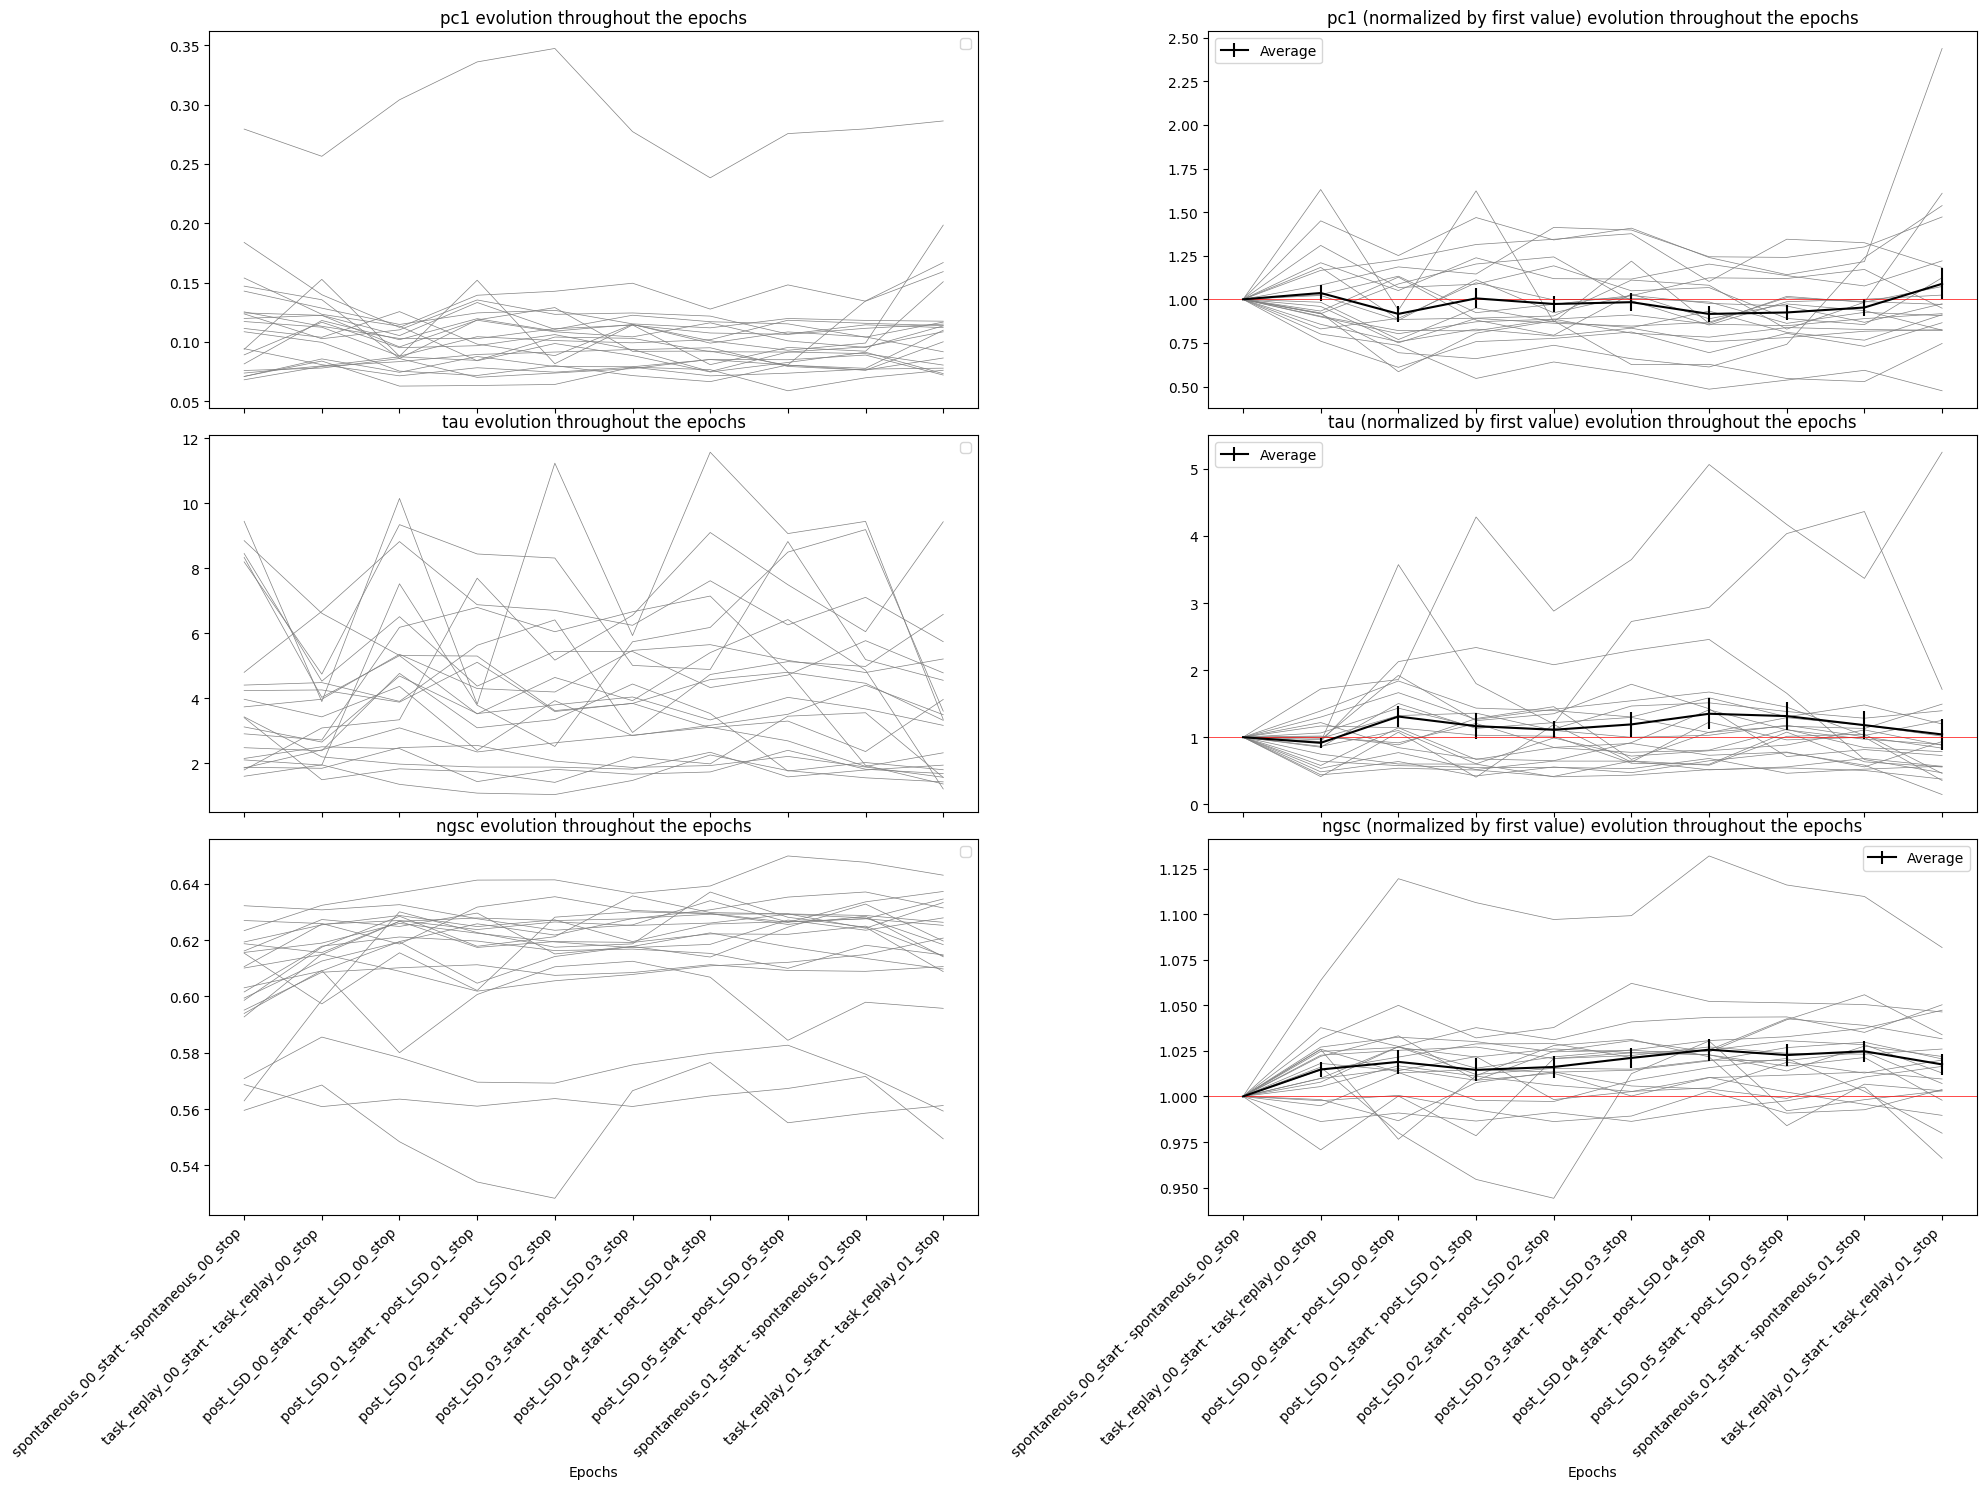

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_metrics_evolutions (df_pca):
    # Set measures
    measures = ['pc1', 'tau', 'ngsc']  

    fig, axs = plt.subplots(len(measures), 2, figsize=(20, 5*len(measures)))

    for i, measure in enumerate(measures):
        all_values = []
        all_ratios = []  # normalized values
        for session in df_pca.index:
            values = []
            ratios = []  # normalized values
            for epoch in df_pca.columns:
                value = df_pca.loc[session, epoch][measure]
                values.append(value)
                if len(values) > 0:
                    ratios.append(value / values[0])  # normalize to the first value

            all_values.append(values)
            all_ratios.append(ratios)

            axs[i, 0].plot(values, color='gray', linewidth=0.5)
            axs[i, 1].plot(ratios, color='gray', linewidth=0.5)

        # Calculate averages and SEM for the ratios
        avg_ratios = np.mean(all_ratios, axis=0)
        sem_ratios = stats.sem(all_ratios)

        axs[i, 1].errorbar(range(len(avg_ratios)), avg_ratios, yerr=sem_ratios, color='black', linewidth=1.5, label="Average")

        # Formatting for both plots
        for j in range(2):
            axs[i, j].set_xticks(range(len(df_pca.columns)))
            
            if j == 1:
                axs[i, j].axhline(1, color='red', linewidth=0.5)  # since data is now a ratio, expect mean around 1
                axs[i, j].set_title(f'{measure} (normalized by first value) evolution throughout the epochs')
            else:
                axs[i, j].set_title(f'{measure} evolution throughout the epochs')

            if i < len(measures) - 1:
                axs[i, j].set_xticklabels([])
            else:
                axs[i, j].set_xticklabels(df_pca.columns, rotation=45, ha="right")
                axs[i, j].set_xlabel('Epochs')

            axs[i, j].legend() 

    plt.tight_layout(h_pad=0.0, w_pad=2.0)
    plt.show()
plot_metrics_evolutions (df_pca)